<a href="https://colab.research.google.com/github/EVA4-RS-Group/Phase2/blob/master/S2_mobilenet_v2_custom_dataset/Training/EVA4_S2_mobilnet_v2_transfer_learning_v4b2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Loading Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!rm -rf final_images
!wget -q https://github.com/EVA4-RS-Group/Phase2/releases/download/s2/final_images_ver2.zip
!unzip -q final_images_ver2.zip
!mv /content/final_images_ver2 /content/final_images
!rm -rf /content/__MACOSX
!find /content/final_images -name '.DS_Store' -type f -delete

In [3]:
# Load modules/models from EVA course
!rm -rf Modules
!git clone https://github.com/EVA4-RS-Group/Phase2 -q --quiet
!mv ./Phase2/Modules ./Modules
!rm -rf Phase2
#print("Loaded EVA4 Modules")
from Modules import *

  pip install torch-lr-finder -v --global-option="amp"


In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()   # interactive mode

# 2. Load Data & Set Data Loaders
We will use torchvision and torch.utils.data packages for loading the data.

The problem we’re going to solve today is to train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.

In [5]:
from Modules import *

In [6]:
split_test_train_data('/content/final_images', tstRatio = 0.3)

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']
6421
3361
4580
4609


In [8]:
batch_size = 192
# class_sample_count = [10, 1, 20, 3, 4] # dataset has 10 class-1 samples, 1 class-2 samples, etc.
# weights = 1 / torch.Tensor(class_sample_count)
# weights = weights.double()
# sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, batch_size)
# trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = batch_size, sampler = sampler)

# target_list = torch.tensor(natural_img_dataset.targets)
# target_list = target_list[torch.randperm(len(target_list))]

# class_count = [i for i in get_class_distribution(natural_img_dataset).values()]
# class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
# class_weights

# class_weights_all = class_weights[target_list]
# class_weights_all

# weighted_sampler = WeightedRandomSampler(
#     weights=class_weights_all,
#     num_samples=len(class_weights_all),
#     replacement=True
# )

# train_loader = DataLoader(dataset=natural_img_dataset, shuffle=False, batch_size=8, sampler=weighted_sampler)

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5404, 0.5918, 0.6219],[0.2771, 0.2576, 0.2998])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5404, 0.5918, 0.6219],[0.2771, 0.2576, 0.2998])
    ]),
}

# data_dir = 'hymenoptera_data'
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
#                                           data_transforms[x])
#                   for x in ['train', 'val']}
#  = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=30,
#                                              shuffle=True, num_workers=4)
#               for x in ['train', 'val']}
# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# class_names = image_datasets['train'].classes

trnTransform = data_transforms['train'] 
trainSet = DroneDataset(train=True, transform = trnTransform)

tstTransform = data_transforms['val']
testSet = DroneDataset(train= False, transform = tstTransform)

dataloaders = {'train': torch.utils.data.DataLoader(trainSet, batch_size= batch_size, 
                                                    shuffle=True, num_workers=4),
               'val': torch.utils.data.DataLoader(testSet, batch_size= batch_size,
                                          shuffle=True, num_workers=4)}

dataset_sizes = {'train': len(trainSet),
                 'val':len(testSet)}

class_names = trainSet.classes
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']


# 3. Visualize a few images
Let’s visualize a few training images so as to understand the data augmentations.

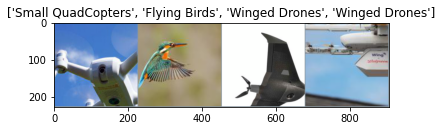

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4,:,:,:])

imshow(out, title=[class_names[int(x)] for x in classes[0:4]])

#6. Finetuning the convnet
Load a pretrained model and reset final fully connected layer.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


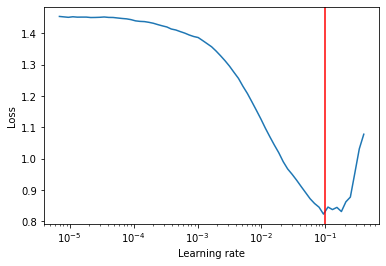

In [11]:
import torch.optim as optim
#from torch_lr_finder import LRFinder

model_ft = models.mobilenet_v2(pretrained=True)
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_ft.classifier[1] = nn.Linear(1280, 4)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_ft.classifier[1].parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.1) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [12]:
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.classifier[1].parameters(), lr=0.1, momentum=0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                          max_lr=0.1, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs 
                                          epochs=25)

# 7. Train and evaluate
It should take around 15-25 min on CPU. On GPU though, it takes less than a minute.

In [13]:
model_res, plotData = train_model(model_ft, dataloaders, dataset_sizes, device, criterion, optimizer_ft, scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 3.4769 Acc: 0.7165
val Loss: 0.8247 Acc: 0.8870

Epoch 1/24
----------
train Loss: 1.4433 Acc: 0.8060
val Loss: 1.2155 Acc: 0.8413

Epoch 2/24
----------
train Loss: 1.1095 Acc: 0.8139
val Loss: 0.6231 Acc: 0.8757

Epoch 3/24
----------
train Loss: 1.0793 Acc: 0.8071
val Loss: 1.4350 Acc: 0.8109

Epoch 4/24
----------
train Loss: 1.1002 Acc: 0.7996
val Loss: 0.5270 Acc: 0.8800

Epoch 5/24
----------
train Loss: 0.9720 Acc: 0.8030
val Loss: 0.5325 Acc: 0.8786

Epoch 6/24
----------
train Loss: 0.8415 Acc: 0.8066
val Loss: 0.4911 Acc: 0.8793

Epoch 7/24
----------
train Loss: 0.7852 Acc: 0.8092
val Loss: 0.4566 Acc: 0.8851

Epoch 8/24
----------
train Loss: 0.7821 Acc: 0.8065
val Loss: 0.5009 Acc: 0.8733

Epoch 9/24
----------
train Loss: 0.9476 Acc: 0.7956
val Loss: 0.8401 Acc: 0.8170

Epoch 10/24
----------
train Loss: 0.8676 Acc: 0.8041
val Loss: 0.6288 Acc: 0.8591

Epoch 11/24
----------
train Loss: 0.8361 Acc: 0.8071
val Loss: 0.6287 Acc: 0.8568

Epoch 12/24
----------
t

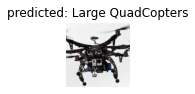

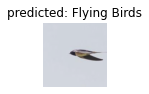

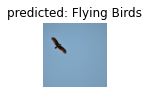

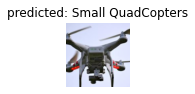

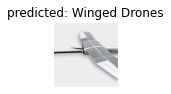

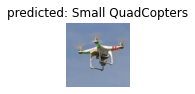

In [14]:
visualize_model(model_res, dataloaders, class_names, device)

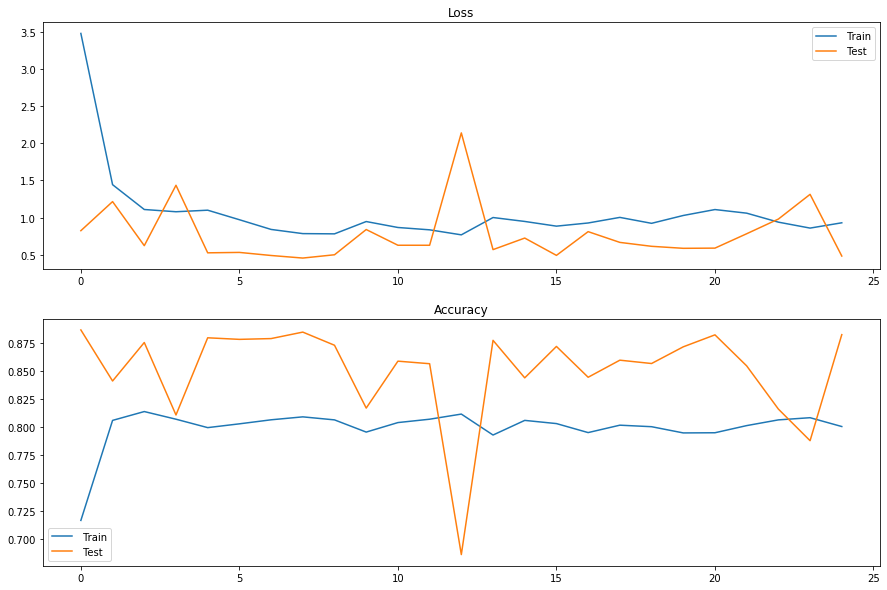

In [15]:
PlotGraph(plotData)

# 8. ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation here.

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


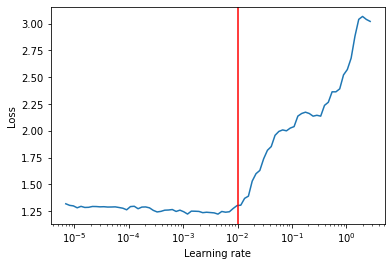

In [16]:
model_conv = model_res
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

model_conv = model_conv.to(device)

for param in model_conv.parameters():
    param.requires_grad = True

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.parameters(), lr=1e-6, weight_decay=0.01,momentum=0.9)
lr_finder = LRFinder(model_conv, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=10, num_iter=100)
lr_finder.plot(show_lr=0.01) # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial stat

In [17]:
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.OneCycleLR(optimizer_conv,
                                          max_lr=0.01, 
                                          steps_per_epoch=len(dataloaders['train']), #Training folder size/bs
                                          epochs=25)

In [18]:
model_final, plotData = train_model(model_conv, dataloaders, dataset_sizes, device, criterion, optimizer_conv, scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0402 Acc: 0.8188
val Loss: 0.6437 Acc: 0.8844

Epoch 1/24
----------
train Loss: 0.6484 Acc: 0.8179
val Loss: 0.3601 Acc: 0.8998

Epoch 2/24
----------
train Loss: 0.4356 Acc: 0.8478
val Loss: 0.2690 Acc: 0.9141

Epoch 3/24
----------
train Loss: 0.3501 Acc: 0.8681
val Loss: 0.2863 Acc: 0.9084

Epoch 4/24
----------
train Loss: 0.3235 Acc: 0.8804
val Loss: 0.2809 Acc: 0.9060

Epoch 5/24
----------
train Loss: 0.2928 Acc: 0.8908
val Loss: 0.2267 Acc: 0.9265

Epoch 6/24
----------
train Loss: 0.2817 Acc: 0.8949
val Loss: 0.2109 Acc: 0.9286

Epoch 7/24
----------
train Loss: 0.2648 Acc: 0.9000
val Loss: 0.1978 Acc: 0.9313

Epoch 8/24
----------
train Loss: 0.2693 Acc: 0.8987
val Loss: 0.1950 Acc: 0.9311

Epoch 9/24
----------
train Loss: 0.2361 Acc: 0.9105
val Loss: 0.1861 Acc: 0.9351

Epoch 10/24
----------
train Loss: 0.2193 Acc: 0.9154
val Loss: 0.1794 Acc: 0.9402

Epoch 11/24
----------
train Loss: 0.2148 Acc: 0.9179
val Loss: 0.1995 Acc: 0.9337

Ep

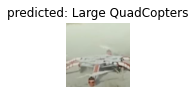

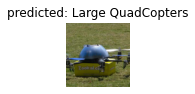

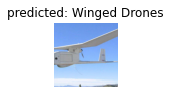

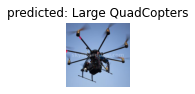

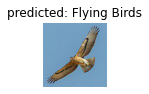

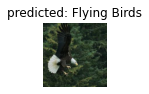

In [19]:
visualize_model(model_final, dataloaders, class_names, device)

plt.ioff()
plt.show()

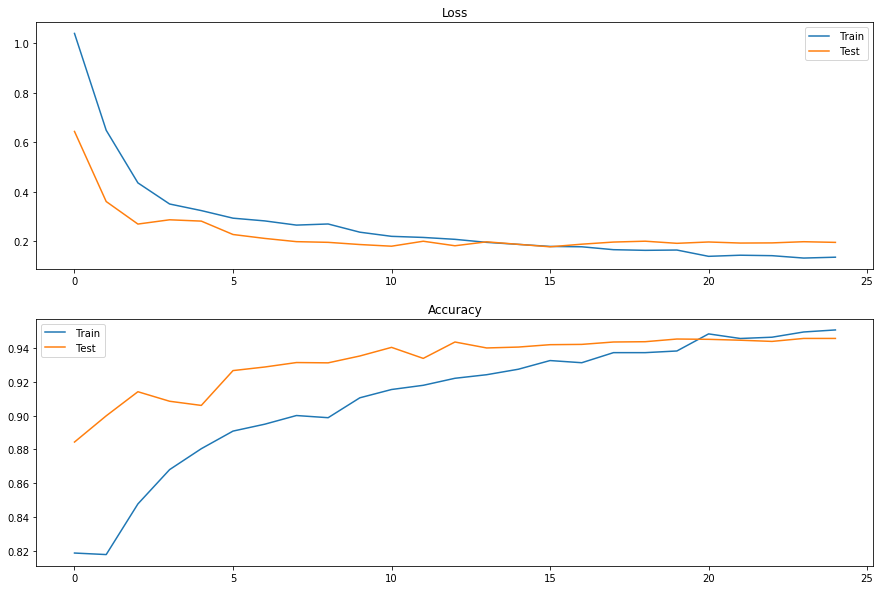

In [20]:
PlotGraph(plotData)

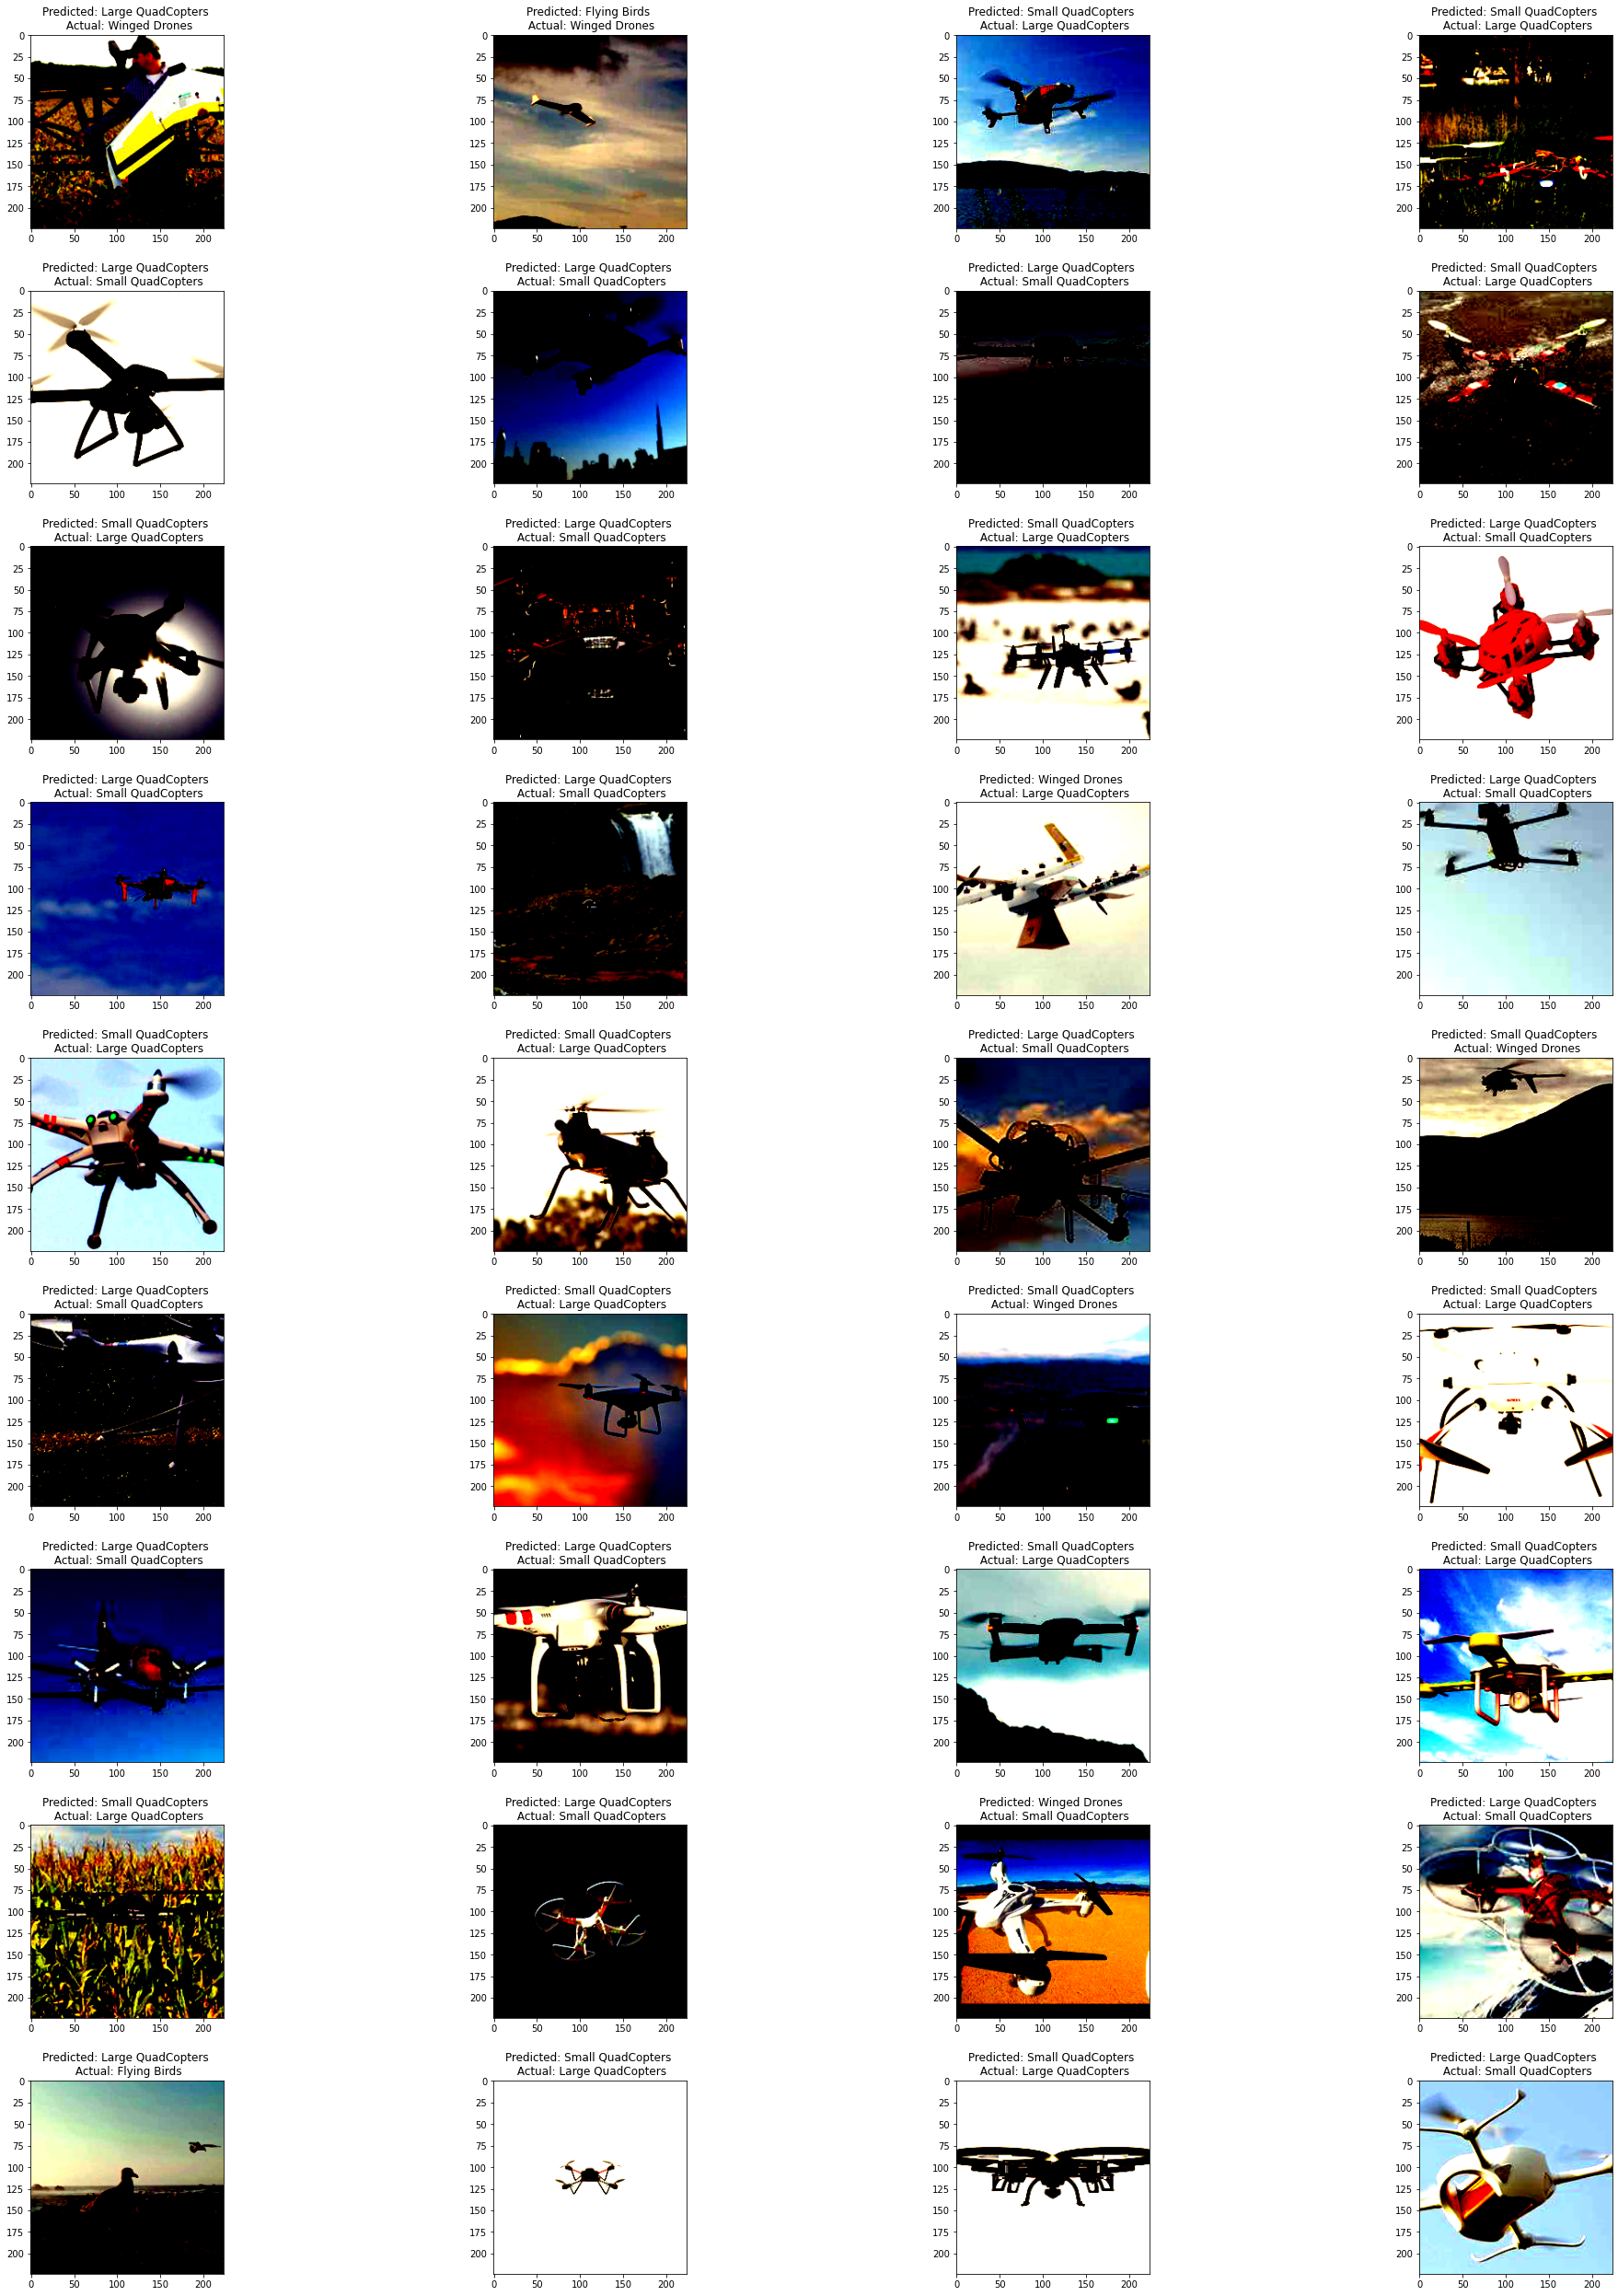

In [21]:
ShowMissclassifiedImages(model_final, dataloaders, class_names, device)

# 9. Saving Model

In [22]:
# Save GPU Model
torch.save(model_final.state_dict(), '/content/mobilenet_v2_custom_trained_gpu_v4b2.pt')

# Load CPU Model
device = torch.device('cpu')
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(1280, 4)
model.load_state_dict(torch.load('/content/mobilenet_v2_custom_trained_gpu_v4b2.pt',
                                 map_location=device))

# Saving Trace Model
model.eval()
# trace model with a dummy input
traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
traced_model.save('mobilenet_v2_custom_trained_v4b2.pt')